<a href="https://colab.research.google.com/github/desultir/assign1/blob/master/MNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer Perceptron in Python
## COMP5329 Assignment 1

## Team:
Anthony Moriarty, 460285074

Ben Daly

Louis Rankin

##1.0 Introduction
The experiment task consisted of building a neural network to perform multi-class classification on a supplied dataset without the use of Deep Learning frameworks (e.g. TensorFlow, Caffe, and KERAS). The dataset consisted of 60,000 labeled training samples and 10,000 unlabeled test samples. The structure of the data (e.g. image, video, etc) was unknown. The performance of the neural network was evaluated in terms of the accuracy metric. Various neural network structures and parameters were trailed to maximise speed and accuracy.

The objective of building the neural network without Deep Learning frameworks was to gain a comprehensive understanding of the math and mechanics behind neural networks. This is important due to the increasing number of fields where neural networks are the state-of-the-art solution for machine learning.

##2.0 Methods
###2.1 Equipment
The programing language Python3 was used to build the neural network. A Google colaboratory image with the following specifications was used to run the neural network:
*   Processor:  Intel(R) Xeon(R) CPU @ 2.30GHz - 1 core
*   Memory: 12 GB
*   Operating system: Linux

###2.2 Preprocessing

Preprocessing data before feeding it to a Neural Network is important for many reasons. Firstly, greatly differing magnitudes between different features can lead to the network assigning false importance to the larger features. Preprocessing also speeds up convergence - centering the data can mitigate the vanishing gradient problem on activation functions such as sigmoid and tanh, while normalization can mitigate the exploding gradient problem with ReLU activation passing through huge net values.

The method selected was z-score normalization. This is a two-step process - run on each feature independetly. First the mean of each feature is subtracted to centre it on zero; secondly the standard deviation is calculated and the feature divided by the standard deviation. The end result is features with zero mean and standard deviation 1. This ensures most of the variance is within the -1 to 1 range where most activation functions have the largest gradient.

The output data was also one-hot encoded to create one column per output class. This maps back to the output of a neural network with one node per output class.

###2.3 Weight Initialization

The goal of weight initialization is to initialize the layers of the network with small random numbers to ensure that different nodes learn different things. We want to preserve variance through the network, so we examine each layer independently with the goal that outputs of a layer should have the same variance as the inputs. In order to preserve this variance for different activation functions, two methods of weight initialization are employed.

Both methods are used to calculate the parameters of a distribution from which weights are selected. Two options are presented to the user - a uniform distribution and a truncated normal distribution. A truncated normal distribution is selected to remove large outliers - any weight with absolute value larger than the maximum of 2 standard deviations has its absolute value set to this limit.  

###2.3.1 Xavier Initialization

For sigmoid and tanh activation functions, the preservation of variance depends on both the number of inputs and the number of outputs of the layer. Firstly, for the truncated normal case, we want to average the number of inputs and outputs to select parameters for our distribution which are optimal for both.

$$Var(W) = \frac{1}{\frac{n_{in} + n_{out}}{2}} = \frac{2}{n_{in} + n_{out}} $$                 
$$\sigma(W) = \sqrt{\frac{2}{n_{in} + n_{out}}} $$

To select bounds for a uniform distribution, we apply the function
$$Var(\mathit{Uniform(-limit, limit)}) = \frac{limit^2}{3} $$
$$Var(W) = \frac{2}{n_{in} + n_{out}}  \Leftrightarrow  limit = \sqrt{\frac{6}{n_{in}+n_{out}}} $$


###2.3.2 He Initialization

For ReLU activation, we encounter the issue that a ReLU unit halves the variance - the variance of negative numbers is nullified. So we must double the above formulae to compensate. One further simplification is that in their original paper, *He. et al* demonstrated that their initialization scheme works for both forward and backward passes, meaning we only need to consider $n_{in}$ and not the average of both. For truncated normal we derive the bounds:
$$ Var(W) = \frac{2}{n_{in}} $$

$$ \sigma(W) = \sqrt{\frac{2}{n_{in}}} $$

Applying the function for the variance of limits from the Xavier Initialization section, we derive the bounds for uniform He initialization:

$$ limit = \sqrt{\frac{6}{n_{in}}} $$

##2.4 Training

### 2.4.1 Gradient Descent
Gradient descent is a machine learning optimization method used in deep learning to calculate the model parameters (weights and biases) that minimise the cost function. The gradient descent method invovles iterating through a training dataset and updating weights and baises in accordance with the gradient of error. There are three types of gradient descent. Each uses a different number of training examples to update the model parameters:
*   **Batch Gradient Descent** uses the entire training dataset to calculate gradients and update the parameters. Because the entire training dataset is considered parameters updates are smooth however, it can take a long time to make a single update.
*   **Stochastic Gradient Descent (SGD)** uses a single randomly selected sample from the training dataset to calculate gradients and update the parameters. Parameter updates are fast but very noisey.
*   **Mini-batch Gradient Descent** uses a subset of the training data (e.g. batches of 1000 samples) to calculate gradients and update the parameters. Mini-batch gradient descent is a compromise between batch and stochastic gradient descent. The mini-batch size can be adjusted to find the appropriate balance between fast convergence and noisey updates. 

Mini-batch gradient descent was inplemented in the neural network due to the flexibility provided by the adjustable mini-batch size. Mini-batch sizes between 32 and 512 samples were used in accordance with the findings of *Keskar et al, 2017.* *Keskar et al* observed that larger batch-sizes resulted in a degradation in the quality of the model, as measured by its ability to generalize. A hybrid of batch gradient descent and stocahastic gradient descent was also implemented. In this method gradients were updated using the same number of samples as the entire training dataset (i.e. 60,000 samples). However, the 60,000 samples were draw stochastically meaning that some sample would have been used multiple times and others not at all. The stochastic approach to batch gradient ensured the neural network was fed data in a different sequence each epoch. This aids the neural networks ability to generalise.

### 2.4.2 Stochastic Gradient Descent (SGD) with Momentum
Momentum ($v_t$) is an exponentially weighted average of a neural networks gradients. It was used to update the weights ($w_t$) and biases ($b_t$) of the network.

$$v_t = \beta v_{t-1} + \eta \nabla_w J(w)$$
$$w_t = w_{t-1} - v_t$$

Momentum increases for features whose gradients point in the same direction and reduces for features whose gradients change direction. By reducing the fluctuation of gradients convergence is generally sped up. The hyper-parameter $\beta$ takes a value between 0 - 1 and dictates how many samples are included in the exponential weighted average. A small $\beta$ value will increase fluctuation because the average is taken over a smaller number of examples. A large $\beta$ will increase smoothing because the average is taken over a larger number of examples. A $\beta$ value of 0.9 was implemented. 0.9 is a widely used value for $\beta$ (*Ruder, 2016*) as it provides a balance between the two extremes of over-smoothing and excessive fluctuations. 


### 2.4.3 Batch Normalization
Batch Normalization is the normalization of a neural network's hidden layers so that the hidden units have standardised mean and variance. It is carried out on training data mini-batches, typically before the activation function is applied *(Ioffe et al, 2015)*. For each mini-batch $(MB)$ the mean $(\mu)$ and variance $(\sigma^2)$ is calculated for all features:

$$\mu_{MB} = \frac{1}{m} \sum_{i = 1}^{m} x_i$$
$$\sigma_{MB}^2 \frac{1}{m} \sum_{i = 1}^{m} (x_i - \mu_{MB})^2 $$

The normalized values of the hidden unit $x_i$ can then be calculated:

$$\tilde{x_i} = \frac{x_i - \mu_{MB}}{\sqrt{\sigma_{MB}^2+\epsilon}}$$

$\tilde{x_i}$ has a mean and variance of 0 and 1 respectively. It may be advantageous to alter the mean and variance of $\tilde{x_i}$ to manipulate its distribution. Learnable hyperparameters $\gamma$ and $\beta$ are introduced to $\tilde{x_i}$ for this purpose:
$$\tilde{x_{i}} = \gamma\tilde{x_i} + \beta $$

While debate remains as to why batch normalization is effective *Ioffe et al* offer two reasons why batch normalization speeds up training. Firstly, as reported above, normalizing the input features of a neural network can speed up learning. This is becuase the cost function becomes more symetrical and larger steps (i.e. larger learning rate) can be taken. The same holds true when the hidden unit values are normalized. The second reason is that batch normalization makes weights deeper in the network more robust to changes that take place in earlier layers. During training the distribution of each layers inputs are adjusted as the parameters of the previous layer change. This is known as internal covariate shift. Batch normalization reduces the amount of covariate shift that occurs throughout the networks layers. This is particuarly benefical for the later layers of the network becausethe earlier layers don't shift as much due to their constrained mean and variance. Batch normalisation therefore allows for larger learning rates. It also means that one can be less careful with the initilisation of weights and bias. A secondary benefit of batch normalization is regularization which helps with model overfit.

##2.5 Regularization

A common issue in machine learning is the tendency to overfit - a model which perfectly describes the training data may fail to generalize when it comes to unseen data. Various methods can be used to regularize the weights of a neural network to ameliorate overfitting.

### 2.5.1 Early Stopping

The simplest method is an attempt to reduce over-training - early stopping. To achieve this, we split the data into a large training set, and a small validation set. The accuracy on the held-out validation set is measured at the end of each epoch and stored. If the accuracy has not improved for a certain number of epochs, we cease training and return the model.

### 2.5.2 Weight Decay

Weight decay is essentially a form of $l2$ regularization. An additional term is added to the loss function to suppress larger weights. Used along with back-propagation, this additional term will see the weights tend to decay toward zero when they would otherwise be untouched. 

The following term is added to the loss function:
$$ \lambda \sum W_{i}^2 $$

During back-propagation, this translates to an additional gradient on each weight of 

$$ 2W * \lambda $$

where $ \lambda $ is an additional parameter of the model - the regularization weight.

### 2.5.3 Dropout

Dropout is a regularisation method patented by Google. It consists of setting the output of neurons in hidden layers to 0 based on a binomial distribution where the probaibility is set as a hyperparameter of the model. The remaining weights are then scaled inversely proportionally to the probaibility set. This is to ensure that the expected magnitude of the neural networks output remains the same as when dropout is not applied (Like during prediction time). 

It can be said that all neural networks use dropout, however most of them apply a probability of 1 effectivly causing no change to the output. This is what was implemented for this assignment with the default probability being set to 1. 

Dropout has also been described as a way of performing model averaging without explicitly training different models like what is done with boosting. This description is used because of any given training example a small subset of the neural network learns how to fit the example. This creates a weak learner. Since the subsets of the neural network all share their weights the result is similar to averaging all of their outputs. More on this idea can be found here: http://papers.nips.cc/paper/4878-understanding-dropout.pdf

##2.6 Activation Functions

Two different activation functions we're implemented as part of this neural network. The Sigmoid and Tanh activation functions were supplied.

### 2.6.1 ReLU

The ReLU also known as Rectified Linear Unit formulation:

$ f(x) = \begin{cases}
    x & \mbox{if } x > 0 \\
    0 & \mbox{otherwise}
\end{cases}$

The ReLU activation function has gained some popularity in part due to the properties of it's gradient. It's derivative is very quick to calculate and does not get extremely small or large. This is because the formulation for its derivative is: 

$ f'(x) = \begin{cases}
    1 & \mbox{if } x > 0 \\
    0 & \mbox{otherwise}
\end{cases}$


A variant of ReLU was also implemented. This variant is called Leaky ReLU. The leaky component of ReLU is because it still retains some information when the input value is less than 0 as described below:

$ f(x) = \begin{cases}
    x & \mbox{if } x > 0 \\
    0.01x & \mbox{otherwise}
\end{cases}$

The derivative for this retains most of the positive properties that the standard ReLU has but this Leaky version results in no dead neurons. This is when a neuron only produces negative values and therefor will only output 0. This means that neurons derivative will also be 0 and it's weights will never change. More on this can be found here: https://arxiv.org/pdf/1505.00853.pdf

$ f'(x) = \begin{cases}
    1 & \mbox{if } x > 0 \\
    0.01 & \mbox{otherwise}
\end{cases}$

### 2.6.2 Softmax
The Softmax activation function is primarily used on the last layer of a neural network so that its outputs resemble a probability distribution. It achieves this by processing a whole layer as a group instead of individual neurons like the other activation functions used. It does this by rescaling or normalising the outputs of the layer to between 0 and 1. It does this to the eponential of all the values. This is because the result is always postive and the result is closer to the result from argmax than regular normalisation is. This is helpful because during prediction time argmax is used but this is not differentiable and so cannot be used in training. 

The specific implementation of softmax used is from the SciPy library. The source code for this can be found here: https://github.com/scipy/scipy/blob/v1.2.1/scipy/special/_logsumexp.py#L132-L215

This particular implementation was used as everything is computed in log space which leads to better numerical stability. 

##2.7 Cost Function

### 2.7.1 Cross Entropy Loss


# 3.0 Analysis

## 3.1 Hyperparameters Search
A random grid search was employed to find the combination of hyper-parameters resulting in the highest accuracy. *Bergstra et al, 2012* showed empirically and theoretically that randomly selected hyper-parameters are more efficient for optimization than a uniform grid search. The hyper-parameters that were searched were:
*   Initialisation (uniform or normal)
*   Dropout (0.2 , 0.4, 0.6, 0.8, 1.0)
*   Activation function (reLu + Softmax or Sigmoid + Tanh)
*   Weight decay (0, 0.05, 0.1, 0.2)
*   Learning rate (0.005, 0.001, 0.1, 0.5)

When a network failed to converge hyper-parameters were adjusted manually in an effort to better understand why. When interesting or unexpected results were observed manual adjustment of hyper-parameters was again carried out to aid understanding.

####Table 1: Random grid search results for two layer network 
Experiment number     |    1 |        2   |   3    |     4     |  5|6    |   7   | 8      |  9  
:--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :---
Number hidden layers      |   2     |    2      |   2   |      2    |     2|2     |    2    |     2     |    2 
Hidden layer node dimensions|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99
Initialisation   |    uni    |  norm   |   norm   |   norm    |  norm   |norm    |   uni    |   uni    |   uni 
Dropout    |   0.6   |    0.6    |     1    |     1    |     1   |1    |   0.4    |   0.2  |     0.6 
Activation functions  | reLU+SM|  Log+Tanh|  Log+Tanh  | reLU+SM |  reLU+SM   |reLU+SM | Log+Tanh | Log+Tanh | Log+Tanh 
Batch normalization     |    n   |      n   |      n    |     n       |  n   |n      |   n   |      n   |      n 
 Weight Decay    |     0   |   0.05    |  0.05  |    0.05   |   0.05  | 0.05     |    0    |  0.05   |   0.05 
Learning Rate     |  0.5   |   0.01  |    0.01   |    0.1   |   0.01   |0.01  |    0.01 |      0.1    |   0.5 
Early Stopping      |   Y    |     Y   |      Y      |   Y    |     Y  | Y     |    Y    |     Y      |   Y 
Epochs   |    500     |  500  |     500    |   500    |   500   |500      | 500   |    500    |   500
Run time (s)    | 49.42  |  281.81  |  281.49   | 436.56  |  803.74   |43.78   |  43.31   |  51.09   |  49.94 
Accuracy | 10.0000% | 10.0000% | 88.4333% | 10.0000% | 86.8556%|87.4556% | 10.0000%  |10.0000% | 10.0000%
\\

Experiment number |10|	11	|12	|13	|14	|15	|16	|17	|18	
:--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- 
Number hidden layers      | 2|	2|	2|	2|	2|	2|	2|	2|	2
Hidden layer node dimensions|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99
Initialisation   | uni	|uni	|norm|	uni|	uni|	uni|	uni|	norm|	norm
Dropout |1	|1	|1	|1	|0.8|	1|	1|	0.4|	0.4
Activation functions  |Log+Tanh|	Log+Tanh|Log+Tanh	|Log+Tanh|	Log+Tanh	|Log+Tanh|	Log+Tanh	|reLU+SM|	reLU+SM	
Batch normalization     |n	|n	|n	|n	|n|	n|	n|	n|	n
 Weight Decay    | 0	|0	|0	|0.05	|0.05|	0.1|	0.2|	0.1|	0.1
Learning Rate     | 0.01	|0.005	|0.005|	0.005	|0.005	|0.005|	0.005	|0.5	|0.5
Early Stopping      |  Y	|Y	|Y	|Y	|Y	|Y	|Y	|Y	|N	
Epochs   |  500|	500|	500|	500	|500	|500	|500	|500	|500
Run time (s)    | 203.10	|356.30	|301.29|	290.92|	326.02	|379.42	|380.94	|51.46|	1636.56|
Accuracy |88.8000%	|88.8222%|	88.7667%|	88.8889%	|87.0556%	|88.9667%	|88.9556%	|10.0000%|	10.0000%
\\



Experiment number  |19|	20|	21	|22	|23	|24	|25|	26
:--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :---
Number hidden layers    |	2|	2  |   2	|2	|2	|2	|2|	2
Hidden layer node dimensions|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99|69 : 99 
Initialisation |	norm|	norm  |    norm	|norm	|norm	|uni|	uni|	uni
Dropout    |    0.4	|0.4|	1	|0.2|	0.2|	0.2|	0.4|	0.4
Activation functions |reLU+SM	|reLU+SM | reLU+SM|	reLU+SM|	reLU+SM	|reLU+SM	|reLU+SM|	reLU+SM
Batch normalization   |	n|	n  |    n	|n	|n	|n	|n	|n
 Weight Decay  |	0.1|	0.1  |   0.05|	0.05|	0.05|	0.1|	0.1|	0.1
Learning Rate    |	0.01	|0.01 |  0.1	|0.01	|0.01	|0.5	|0.01	|0.01
Early Stopping   |Y	|N   |   Y	|Y	|Y	|Y	|Y|	N
Epochs  	|500	|100 |   500	|500|	500	|500|	500	|500
Run time (s)  |	52.08|	439.40  | 51.97	|55.91|	81.83	|54.43|	51.51|	1597.43
Accuracy|	10.0000%|	10.0000% | 10.0000%	|10.0000%	|85.8333%|	10.0000%	|10.0000%	|10.0000%

\\



Experiment number  	27	|28|	29|	30	|31	|32|33
:--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :---
Number hidden layers    |3	|3	|3	|3	|3	|3		
Hidden layer node dimensions|69 : 69 : 99|69 : 69 : 99|69 : 69 : 99|69 : 69 : 99|69 : 69 : 99|69 : 69 : 99
Initialisation |norm	|norm	|norm	|norm|	norm|	norm
Dropout    |    1|1	|1|	1|	1|	1
Activation functions |Log+Tanh	|Log+Tanh	|reLU+SM|	reLU+SM	|reLU+SM|	reLU+SM
Batch normalization   |n	|n	|n	|n	|n|	n
 Weight Decay  |	0.05	|0|	0.05|	0.05|	0.05|	0.05
Learning Rate    |	0.01|	0.01	|0.01|	0.01	|0.01|	0.01
Early Stopping   |Y	|Y|	Y|	Y|	Y|	Y
Epochs  	|500|500|500|10|11|12|
Run time (s)  	|212.0	|180.7|	156.6|	48.7|	54.7|	59.5
Accuracy|	88.4667%|	88.2889%|	75.0444%|	87.3000%|	86.8222%|	86.8889%
\\


Experiment number  |34	|	35	|	36	|	37	|	38	|	39
:--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :---
Number hidden layers |3|3|2|2|3|3
Hidden layer node dimensions|69 : 69 : 99|69 : 69 : 99|69 : 99|69 : 99|99 : 69 : 39|99 : 69 : 39
Initialisation |norm	|uni|	uni	|uni	|uni	|uni
Dropout    |    1|	1|0.9|	0.9|	0.9|	0.9
Activation functions |reLU+SM	|Log+Tanh	|Log+Tanh	|LogSLogig+Tanh	|Log+Tanh|	reLU+SM
Batch normalization   |n	|n	|n	|n	|n|	n
 Weight Decay  |	0.05	|0|	0.1|	0.1|	0.1|	0.1
Learning Rate    |	0.01	|0.01	|0.005	|0.005|	0.005|	0.005
Early Stopping   | Y	|Y|	Y|	Y|	Y|	Y
Epochs  	|20|500|	500	|500|	500	|500
Run time (s)  	|99.1|	196.7	|524.0|	454.0	|532.0|	250.0
Accuracy|	85.6667%	|87.9778%	|88.4800%	|88.5100%	|88.5400%	|88.8700%
\\

![accuracy figure](https://drive.google.com/uc?authuser=0&id=176Y_9skf-H8x3K_FFCAooagnaxx34ZHb&export=download)
*Figure 1: Accuracy and runtime across all experiments*


Above is a graph of the accuracy across all our experiments, with the optimal model at the rightmost column. It can be seen that this has near highest accuracy and a middle of the range runtime. This is discussed further in section 4.0.

## 3.2 Learning Rate
Learning rate (LR) is a hyper-parameter that dictates how large the adjustment of weights and biases are with respect to the calculated gradient. It controls how quickly quickly or slowly a network is able to learn a problem. Reducing the learning rate reduces the size of the steps towards the local minima (i.e. the best accuracy). A small learning rate helps ensure that the local minima is not missed but it also slows down convergence. A larger learning rate speeds up convergence with larger steps but may miss the local minima. Four different values of LR were used in the random grid search. A summary of results is shown below. It can be seen that as the LR decreases mean accuracy and run time increase.

Learning Rate | Metric | Mean | SD | Count
:---:|:---:|:---:|:---:|:---:
0.005|Acc|88.576%|0.749%|6
0.005|Runtime (sec)|339.1|	39.0|	6
0.001|Acc|86.283%|3.650%|13
0.001	|Runtime (sec)|	178.4|	209.6|	13
0.1|Acc|NA|NA|3
0.5|Acc|NA|NA|5

All networks with LR greater than 0.01 failed to converge. This is most likely the result of overflow (i.e. exploding gradients). Overflow occurs when network updates $(LR*gradient)$ become extremely large due to accumulation through the network. Exponential growth occurs by repeatedly multiplying gradients through the network layers that have values greater than one. Deeper networks and larger learning rates increase the likelihood of overflow. Appropriate selection of weight initialisation can reduce overflow. For neural networks using the reLU activation function 'He' initialization was employed. For neural networks using the logistic activation function the 'Xavier' initialization was used.

## 3.3 Activation Functions
Two activation functions were used in the random grid trails:
1.   Logistic hidden layers with tanh output layer.
2.   reLU hidden layer activation with softmax output activation. 

On average the logistic - tanh combination outperformed reLU - softmax on accuracy but not on run time. The quicker run time of reLU - softmax was an expected result. reLU is a simpler function with a simple derivative making backward and forward propagation faster. Dispite logistic - tanh activation function performing better on average, peak accuracy was higher using the reLU activation function. The peak accuracy achieved by reLU versus logistic was marginal (88.87% vs 88.48% respectively) but the difference in runtime was significant (250s vs 524s respectively).

Activation Function | Metric | Mean | SD | Count
:---:|:---:|:---:|:---:|:---:
Log+Tanh	|Acc (%)	|88.497%	|0.497%|	13
Log+Tanh	|Runtime (sec)|	282.6	|72.8|	13
reLU+SM	|Acc (%)	|85.637%	|4.0.81%|9
reLU+SM|	Runtime (sec)	|168.5|	259.3|	9


Softmax was used exclusively for the last layer of the neural networks because it provides an output resembling a probability distribution. Tanh was used prodominately as an output but can be used in hidden layers because it is a sigmoid function. Tanh differs from logistic in that it maps input bewteen -1 and 1 (logistic maps inputs between 0 and 1). An additional trial was conducted to compare a neural network with all tanh activation functions versus one with all logistic activation functions. Accuracy results were compariable however the tanh network had a significantly faster run time. This is because the tanh function produces stronger gradients resulting in faster convergence *(LeCun et al, 2012)*.


Learning Rate | Acc (%) | Runtime (sec) 
:---:|:---:|:---:
Logistic|88.6%|298.2
Tanh|88.67%|167.6
Log+tanh|88.8%|324.4

## 3.4 Weight Initialization
Two methods for weight initialization were investigated – these are outlined in section 2. The methods (He and Xavier) are used for setting the bounds of distributions from which weights are drawn. The method is selected based on the activation functions of a given layer, so these are not considered hyperparameters of the model. What is made available to the user however is the distribution from which weights are drawn.

Our random grid search explored selection of weights from both a uniform and a truncated normal distribution. The results are as follow:


Distribution |  Acc (%) mean	| stddev	
:---:|:---:|:---:
Normal |	87.14%	| 1.09%
Uniform |	88.58% |	0.75%

Using a uniform distribution has a better accuracy, with a tighter standard deviation. The original Xavier paper $\cite{Glorot10understandingthe}$ does use a uniform distribution – so perhaps this is not a surprise. The He paper $\cite{he2015delving}$ prefers a normal distribution, which is interesting when one considers the following breakout:


Algorithm | Distribution |  Acc (%) mean	| stddev	
:---:|:---:|:---:|:---:
Xavier | Normal |	88.43% |	0%
Xavier | Uniform |	88.58%	| 0.75%
He | Normal |	87.14%	| 1.09%
He | Uniform |	NA | 	NA 

Uniform Xavier does perform better than normal-distribution Xavier. What is more interesting is that uniform-based He did not converge during our experiments. Whether this is due to confounding factors (ie other modules selected in the random grid) could be the topic of further investigation.

## 3.5 Weight Decay
Weight decay is a regularization method which penalizes large weights with a gradient proportional to the size of the weight. 2 values were made available in our random grid search. The results follow:


Weight Decay | Acc (%)	mean |	stddev
:---:|:---:|:---:|
0 |	88.80% |	0.03%
0.05 |	87.42%	| 1.11%

Weight decay decreases accuracy. This may be due to our using it in parallel with 2 other forms of regularization – early stopping and dropout. Early stopping does not penalize large weights in particular, but attempts to stop training before overfitting occurs. Dropout removes weights at random attempting to strengthen lesser used paths. Both of these may be providing enough regularization to prevent overfitting meaning the indiscriminate regularization of weight decay only negatively affects the result.


## 4.0 Optimal Model

The random grid search experiment 15 had the highest accuracy. This was used as a base for further investigation - with manual tweaking of hyperparameters with the interest of increasing generalization as well as accuracy. The final, optimal model had the following features:


Parameter | Value
:---:|:---:|
Number hidden layers | 3
Hidden layer node dimensions|99 : 69 : 39
Weight Initialisation |uniform
Dropout    |  0.9
Activation functions |	reLU+SM
Batch normalization   | n
 Weight Decay  |	0.1
Learning Rate    |	0.005
Early Stopping   | Y
Max Epochs  	|500
Run time (s)  	|250.0
Accuracy|	88.8700%
\\

The depth of the network was increased to 3 as this led to a small bump in accuracy (0.5% gain). The decision was also made to add some dropout to the model to aid generalization, as it was felt that real world data may not exhibit the exact same characteristics as the training data.

### 4.1 Instructions for running

The optimal model can be trained by calling train_optimal(data, labels). The final cell of this notebook contains code for training and predicting, along with calculating accuracy.

## 5.0 Discussion

The final model achieved accuracy of 88.87%. This was not the highest accuracy achieved in all experiments, however the decision was made to include dropout even at a cost of accuracy to increase generalization. The layout was selected based on the results of the random grid search, however the activation function of reLU was selected despite its performing poorer in the grid search. It was found with this particular set of parameters reLU does boost the accuracy.


The random grid search is an effective method of quickly trialling combinations of modules. Given the highly dependent nature of the effect of different modules in a neural network, exploring hyperparameters separately gives no indication what will happen when they are employed together. Due to the large number of hyperparameters of our model, a traditional grid search would be unfeasible. The random grid search gets some of the benefits of a traditional grid search, inasfar as it explores interplay between hyperparameters, in far less time. It was unfortunate however that due to constraints we couldn’t include all modules in our random grid search.


Minibatch was used for all experiments due to time constraints, with other fitting methods (ie momentum) only explored in early experimental stages and as a test on our final model. Early stopping was used for similar reasons.


Other combinations of activation functions (ie Sigmoid+Sigmoid) could have been investigated in the grid, however early experimentation pointed to Sigmoid+Tanh being the best combination of logistic functions. The same experiment was run on our final model (Sigmoid + TanH vs reLU vs all-sigmoid vs all-tanh). This was where reLU was selected as finally the best activation method with this combination of hyper-parameters.

Another method we could have investigated given more time was much larger network layers with some enforcement of sparsity. 

We had much difficulty with the implementation of batch normalization – to learn the two variables gamma and beta requires an extension of the backpropagation algorithm, which required understanding the existing code and extending it. This feature was only completed in the final days of the project, meaning that much of the experimentation was already complete. It was, however, a very valuable endeavour to come to understand the delta-rule-based backpropagation method employed by the template code. It is impressive how highly parallel and simple this method is compared to separately calculating partial derivatives for each node in a layer with respect to each output node.

It is assumed by inspecting the input data that this is a modified version of an image classification problem – potentially MNIST. The data has likely been run through a convolution and pooling step before being given to us. If this is the case, our final accuracy of around 89% is quite acceptable, given that human performance on this task is around the 83% mark.\cite{xiao2017/online} Human-like performance is often the goal of such tasks – achieving much better than human performance can be near impossible given potential noise in the labels which were generated by humans themselves.

## 6.0 Conclusion

Tuning of deep learning systems is a difficult and time consuming process. The interplay between the effects of different hyper-parameters on model performance, along with the exploding gradients problem and other non-convergence effects, means that a random grid search is one of the better methods of tuning.

With the assumption that this is an MNIST-like problem, we have achieved accuracy similar to the state of the art of around 90%. Given infinite resources, a full grid search may have found an extra boost in accuracy but the decision was made to favour generalization over optimum accuracy. This is due to the expectation that real-world data may exhibit characteristics not seen in the training set.

In [0]:
!pip install --upgrade scipy
!pip install --upgrade numpy


Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.2.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.3)


In [0]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import h5py
from google.colab import drive
import time
import pandas as pd

In [0]:
drive.mount('/content/drive', force_remount=True)
with h5py.File('/content/drive/My Drive/Colab Notebooks/Input/train_128.h5','r') as H:
  data = np.copy(H['data'])
with h5py.File('/content/drive/My Drive/Colab Notebooks/Input/train_label.h5','r') as H:
  label = np.copy(H['label'])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# need to normalize input data to avoid overflow/underflow in initial epochs
# normalize each feature independently
# options are zscore, minmax
def preprocess(input_array, method='zscore'):
  if method == 'zscore':
    for i in range(input_array.shape[1]):
      mean = np.mean(input_array[:, i])
      std = np.std(input_array[:, i])
      input_array[:, i] = (input_array[:, i] - mean) / std
  elif method == 'minmax':
    for i in range(input_array.shape[1]):
      # range 0 to max
      input_array[:, i] = (input_array[:, i] - np.min(input_array[:, i]))
      # range 0 to 2
      input_array[:, i] /= (np.max(input_array[:, i]) / 2)
      # range -1 to 1
      input_array[:, i] -= 1
      

In [0]:
#use stratified sampling to split train into train/validation
#this dataset is actually balanced but still good practice
def split(dataset, labels, train_percent=.85):
  count = len(dataset)
  num_classes = np.max(label) + 1
  train = []
  train_target = []
  validate = []
  validate_target = []
  for i in range(num_classes):
    class_data = np.ravel(np.argwhere(label == i))
    np.random.shuffle(class_data)
    cutoff = int(len(class_data) * train_percent)
    train_idx = class_data[:cutoff]
    val_idx = class_data[cutoff:]
    train.append(dataset[train_idx])
    train_target.append(labels[train_idx])
    validate.append(dataset[val_idx])
    validate_target.append(labels[val_idx])
    
  return np.vstack(train), np.hstack(train_target), np.vstack(validate), np.hstack(validate_target)

In [0]:
#need to one-hot encode labels to map to N output nodes (1 per class)
#ie convert each label into a (10,) vector where the relevant column is 1

def OHE(input_array, num_classes=10):
  output = []
  for x in input_array:
    output.append(np.zeros((10,)))
    output[-1][x] = 1
  return np.vstack(output)

In [0]:
## implemented formulae from here: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
class InitWeights(object):
  def xavier(self, n_in, n_out, uniform=True):
    if uniform:
      bounds = np.sqrt(6) / (np.sqrt(n_in + n_out))
      return self._uniform(n_in, n_out, bounds) 
    else:
      stddev = np.sqrt(2) / (np.sqrt(n_in + n_out))
      return self._truncated_normal(n_in, n_out, stddev)
    
  def he(self, n_in, n_out, uniform=True):
    if uniform:
      bounds = np.sqrt(2) / (np.sqrt(n_in))
      return self._uniform(n_in, n_out, bounds)      
    else:
      stddev = np.sqrt(6) / (np.sqrt(n_in))
      return self._truncated_normal(n_in, n_out, stddev)
 
  def _uniform(self, n_in, n_out, bounds):
    W = np.random.uniform(
        low=-bounds,
        high=bounds,
        size=(n_in, n_out)
      )
    return W
  
  def _truncated_normal(self, n_in, n_out, stddev):
    W = np.random.normal(
        loc=0,
        scale=stddev,
        size=(n_in, n_out)
      )
    #truncate results - anything > 2 stddev out gets clipped
    W[W> 2*stddev] = 2*stddev
    W[W<-2*stddev] = -2*stddev
    return W
  
  def __init__(self, init_method="xavier"):
    if init_method=="xavier":
      self.f = self.xavier
    elif init_method=="he":
      self.f = self.he

In [0]:
def calc_MSE(y, y_hat):
  error = y-y_hat
  return np.mean(np.sum(error**2, axis=1))

def labels_from_preds(preds):
  return np.argmax(preds, axis=1)

def calc_accuracy(labels, target):
  return np.sum(labels == target) / len(target)

#wasn't sure if we could use a package to shuffle so found this code: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
  
  

In [0]:
from scipy.special import softmax

class Activation(object):
    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
      
    def ReLU(self, x):
        x[x<0] =0
        return x
      
    def ReLU_deriv(self, a):
        der = np.zeros(a.shape)
        der[a>0] =1
        return der
      
    def leaky_ReLU(self, x):
        x = np.where(x > 0, x, x*0.01)
        return x
      
    def leaky_ReLU_deriv(self, a):
        der = np.full(a.shape, 0.01)
        der[a>0] =1
        return der
      
    def softmax(self, x):
        # apply max normalization to avoid overflow
        if len(x.shape) > 1:
          x_norm = (x.T - np.max(x, axis=1)).T
          return softmax(x_norm, axis=1)
        else:
          x_norm = x - np.max(x)
          return softmax(x_norm)
      
    def softmax_deriv(self, a):
        return np.ones(a.shape)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.logistic
            self.f_deriv = self.logistic_deriv
        elif activation == 'tanh':
            self.f = self.tanh
            self.f_deriv = self.tanh_deriv
        elif activation == 'relu':
            self.f = self.ReLU
            self.f_deriv = self.ReLU_deriv
        elif activation == 'leaky_relu':
            self.f = self.leaky_ReLU
            self.f_deriv = self.leaky_ReLU_deriv
        elif activation == 'softmax':
            self.f = self.softmax
            self.f_deriv = self.softmax_deriv
            

In [0]:
class Loss_function(object):
    def MSE(self, y, y_hat):
        error = y-y_hat
        loss=np.sum(error**2)
        return loss
      
    def Cross_entropy(self, y, y_hat):
        return -np.log(y_hat[np.argmax(y)])
      
    def l2_reg(self, reg_weight, layers, sample_weight):
        accum = 0
        for layer in layers:
          accum += np.sum(np.square(layer.W))
          
        return accum*reg_weight*sample_weight/2
        
    def __init__(self,loss='cross_entropy'):
        if loss == 'MSE':
            self.loss = self.MSE
        elif loss == 'cross_entropy':
            self.loss = self.Cross_entropy

In [0]:

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None,
                init_uniform=True, weight_decay=None, last_layer=False):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        :type init_uniform: bool
        :param init_uniform: Whether to draw init weights from uniform dist (else normal)
        
        :type weight_decay: float/None/False
        :param weight_decay: Weight to apply to l2 reg loss factor (else none/false)
        """
        self.input=None
        self.dropout_cache=None
        self.activation=Activation(activation).f
        self.last_layer=last_layer
        
        if activation=='relu':
          self.init_weights = InitWeights("he").f
        else:
          self.init_weights = InitWeights("xavier").f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        if W is not None:
          self.W = W
        else:
          self.W = self.init_weights(n_in, n_out, init_uniform)

        if b is not None:
          self.b = b
        else:
          self.b = np.zeros(n_out,)  
          
        self.weight_decay = weight_decay
          
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # create arrays to store the velocity values for momentum calculation
        self.vW = np.zeros(self.W.shape)
        self.vb = np.zeros(self.b.shape)
        
        # Create arrays to store the gamma and beta values for batch norm. @
        self.gamma = np.zeros(n_out,)
        self.beta = np.zeros(n_out,)
        
        self.grad_gamma = np.zeros(self.gamma.shape,)
        self.grad_beta = np.zeros(self.beta.shape,)
    
    def dropout(self, nodes, probability):
        #This distribution decides what nodes will be on or not. We then rescale the on nodes proportionally to the probability that it is off.
        
        active_nodes = np.random.binomial(1, probability, size=nodes.shape) / probability
        output = np.multiply(nodes, active_nodes)
        return output, active_nodes
    
    def forward(self, input, probability):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        
        if self.last_layer:
            probability=1
        
        self.output, self.dropout_cache = self.dropout(self.output, probability)
        return self.output
    
    def backward(self, delta, output_layer=False, sampleweight=1):
        delta *= self.dropout_cache
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        
        if self.weight_decay:
            self.grad_W += self.W * self.weight_decay * sampleweight
        self.grad_b = np.sum(delta, axis=0)
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta
      
    def forward_BN(self, input, probability, fit):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        self.lin_output = np.dot(input, self.W) + self.b
        
        '''
        This is where batch norm is implemented
        '''
        if self.last_layer:
            probability=1
        else:
            if fit:

              self.layer_mu = np.mean(self.lin_output, axis=0)
              self.layer_var = np.var(self.lin_output, axis=0)

              self.lin_output_norm = (self.lin_output - self.layer_mu) / np.sqrt(self.layer_var + 1e-8)


              self.bn_mean = 0.9 * self.bn_mean + (1 - 0.9 ) *  self.layer_mu
              self.bn_var = 0.9 * self.bn_var + (1 - 0.9 ) *  self.layer_var
            else:
              self.lin_output_norm = (self.lin_output - self.bn_mean) / np.sqrt(self.bn_var + 1e-8)

            self.lin_output = self.bn_gamma * self.lin_output_norm + self.bn_beta
        
        
        
        self.output = (
            self.lin_output if self.activation is None
            else self.activation(self.lin_output)
        )
        self.input=input
        

        
        self.output, self.dropout_cache = self.dropout(self.output, probability)
        return self.output                                       

    def backward_BN(self, delta, dy_hat, output_layer=False, sampleweight=1):
        

        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        
        if self.weight_decay:
            self.grad_W += self.W * self.weight_decay * sampleweight
        self.grad_b = np.sum(delta, axis=0)

            
        delta *= self.dropout_cache
           
        if not self.last_layer:  
            N, D = self.lin_output.shape


            input_mu = (self.lin_output - self.layer_mu)
            std_inv = 1. / np.sqrt(self.layer_var + 1e-8)

            dinput_norm = delta * self.bn_gamma
            dvar = np.sum(dinput_norm * input_mu, axis=0) * -0.5 * (self.layer_var + 1e-8)**(-3/2)
            dmu = np.sum(dinput_norm * -std_inv, axis=0) + dvar * np.mean(-2. * input_mu, axis=0)

            delta = (dinput_norm * std_inv) + (dvar * 2 * input_mu / N) + (dmu / N)
            self.grad_bn_gamma = np.sum(delta * self.lin_output_norm, axis=0)
            self.grad_bn_beta = np.sum(delta, axis=0)
        
        
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
                
        return delta
      

In [0]:

class MLP:
    """
    """      
    def __init__(self, layers=None, activation=[None,'tanh','tanh'], init_uniform=True, weight_decay=False, from_file=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        :param init_uniform: Whether to draw init weights from uniform dist (else normal)
        :param weight_decay: lambda for strength of l2 regularization on weights (else False/None for no reg)
        :param from_file: a file to load to get pretrained weights. 
        """        
        ### initialize layers
        self.layers=[]
        self.params= {'activation':activation, 'layers':layers, 'weight_decay': weight_decay, 'init_uniform': init_uniform}
        
        self.es_epochs=None
        if from_file:
          dumped_model = self._load_model(from_file)
          self.params = dumped_model['params']
          self.activation=self.params['activation']
          layers = self.params['layers']
          init_uniform = self.params['init_uniform']
          for i in range(len(self.params['layers'])-1):
              if i==len(self.params['layers'])-2:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],  
                                              W=dumped_model['weights'][i][0], b=dumped_model['weights'][i][1], weight_decay=weight_decay, init_uniform=init_uniform,last_layer=True))
              else:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],  
                                              W=dumped_model['weights'][i][0], b=dumped_model['weights'][i][1], weight_decay=weight_decay, init_uniform=init_uniform))
        else:
          self.activation=activation
          for i in range(len(layers)-1):
              if i==len(layers)-2:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1], weight_decay=weight_decay, init_uniform=init_uniform,last_layer=True))
              else:
                self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1], weight_decay=weight_decay, init_uniform=init_uniform))
    
    def forward(self,input, dropout_p=1):
        for layer in self.layers:
            output=layer.forward(input, dropout_p)
            input=output
        return output
    
    #@ Can combine this with forward above with an if statement. Just wanted to keep separte for now until I know it works.
    def Forward_BN(self,input, dropout_p=1, fit=True):
        for layer in self.layers:
            output =layer.forward_BN(input, dropout_p, fit=fit)
            input=output
        return output
      
    def set_early_stopping(self, validation, validation_labels, num_epochs=10):
        # for early stopping
        self.validation = validation
        self.validation_labels = labels_from_preds(validation_labels)
        self.es_epochs = num_epochs
      
    def calculate_loss(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # call to loss function
        loss=[]
        delta=[]
        dy_hat=[] # store derivative of output for use in BN_backward @

        for i, single_y in enumerate(y):
          loss.append(Loss_function('MSE').loss(single_y, y_hat[i]))
          error = single_y-y_hat[i]
          # calculate the delta of the output layer
          delta.append(np.array(-error*activation_deriv(y_hat[i])))
        # return loss and delta
        loss = np.array(loss)
        if self.params['weight_decay']:
          loss += Loss_function().l2_reg(self.params['weight_decay'], self.layers, len(y)/self.Xcount)

        return loss,np.array(delta)
        
    def backward(self,delta, sampleweight):
        delta=self.layers[-1].backward(delta,output_layer=True, sampleweight=sampleweight)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta, sampleweight=sampleweight)
    
    #@ can combine this with backwards above with an if statement. Just wanted to keep separte for now until I know it works.
    def Backward_BN(self, delta, dy_hat, sampleweight):
        delta =self.layers[-1].backward_BN(delta, dy_hat, output_layer=True, sampleweight=sampleweight)
        for layer in reversed(self.layers[:-1]):
            delta =layer.backward_BN(delta, dy_hat, sampleweight=sampleweight)                
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
            
    def update_momentum(self, lr, mom):
        for layer in self.layers:
            layer.vW = mom * layer.vW + lr * layer.grad_W
            layer.vb = mom * layer.vb + lr * layer.grad_b
            layer.W -= layer.vW
            layer.b -= layer.vb 
            
    def update_BN(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
            layer.bn_gamma -= lr * layer.grad_bn_gamma
            layer.bn_beta -= lr * layer.grad_bn_beta       

    def fit(self,X,y,learning_rate=0.1, epochs=100, dropout_p=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        self.Xcount = len(X)
        if self.es_epochs:
            validation_acc = np.zeros(epochs)
        for k in range(epochs):
            #print('epoch', k)
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i], dropout_p)
                # backward pass
                loss[it],delta=self.calculate_loss([y[i]],[y_hat])
                self.backward(delta, 1/self.Xcount)
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
            if not k % 10:
              print(".", end="")
            if self.es_epochs:
              preds = self.predict(self.validation)
              validation_acc[k] = calc_accuracy(labels_from_preds(preds), self.validation_labels)
              if k - np.argmax(validation_acc) > self.es_epochs:
                print("Haven't improved accuracy on validation set in {} epochs, stopping".format(self.es_epochs))
                break
        return to_return
      
    def fit_mb(self,X,y,mini_batch_size,learning_rate=0.1, epochs=100, dropout_p=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        :param early_stop: int: stop if haven't improved in this many epochs
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs) #array to store values of mean loss for each epoch for plotting later
        if self.es_epochs:
            validation_acc = np.zeros(epochs)
        self.Xcount = len(X)
        
        for k in range(epochs): #for each epoch
            X, y = shuffle_in_unison(X, y) #shuffle the input data and input targets
            loss=np.zeros(X.shape[0]) #create array of zeros whose lengths = #samples.
            
            #partition training data (X, y) into mini-batches
            for j in range(0, X.shape[0], mini_batch_size):
              X_mini = X[j:j + mini_batch_size]
              y_mini = y[j:j + mini_batch_size]
              # forward pass
              y_hat = self.forward(X_mini, dropout_p) #forward feed the mini_batches to get outputs (y_hat)
              
              # backwards pass
              loss[j:j + mini_batch_size], delta=self.calculate_loss(y[j:j + mini_batch_size], y_hat) #input y and y_hat into calculate_loss. Output = loss and delta
              self.backward(delta, mini_batch_size/self.Xcount) #pass delta from calculate_loss to backward.

              # update
              self.update(learning_rate)
            to_return[k] = np.mean(loss) #add mean loss to to_return
            if not k % 10:
              print(".", end="")
            if self.es_epochs:
              preds = self.predict(self.validation)
              validation_acc[k] = calc_accuracy(labels_from_preds(preds), self.validation_labels)
              if k - np.argmax(validation_acc) > self.es_epochs:
                print("Haven't improved accuracy on validation set in {} epochs, stopping".format(self.es_epochs))
                break
              
        return to_return[:k]
      
    def fit_mb_BN(self,X,y,mini_batch_size,learning_rate=0.1, epochs=100, dropout_p=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        :param early_stop: int: stop if haven't improved in this many epochs
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs) #array to store values of mean loss for each epoch for plotting later
        if self.es_epochs:
            validation_acc = np.zeros(epochs)
        self.Xcount = len(X)
        
        for k in range(epochs): #for each epoch
            X, y = shuffle_in_unison(X, y) #shuffle the input data and input targets
            loss=np.zeros(X.shape[0]) #create array of zeros whose lengths = #samples.
            
            #partition training data (X, y) into mini-batches
            for j in range(0, X.shape[0], mini_batch_size):
              X_mini = X[j:j + mini_batch_size]
              y_mini = y[j:j + mini_batch_size]
              # forward pass
              y_hat = self.Forward_BN(X_mini, dropout_p, fit=True) #forward feed the mini_batches to get outputs (y_hat)
              
              # backwards pass
              loss[j:j + mini_batch_size], delta=self.calculate_loss(y[j:j + mini_batch_size], y_hat) #input y and y_hat into calculate_loss. Output = loss and delta
              self.Backward_BN(delta, dy_hat, mini_batch_size/self.Xcount) #pass delta from calculate_loss to backward.

              # update
              self.update_BN(learning_rate)
            to_return[k] = np.mean(loss) #add mean loss to to_return
            if not k % 10:
              print(".", end="")
            if self.es_epochs:
              preds = self.predict(self.validation)
              validation_acc[k] = calc_accuracy(labels_from_preds(preds), self.validation_labels)
              if k - np.argmax(validation_acc) > self.es_epochs:
                print("Haven't improved accuracy on validation set in {} epochs, stopping".format(self.es_epochs))
                break
              
        return to_return[:k]
      
    def fit_SGD_momentum(self,X,y,learning_rate=0.1, epochs=100, momentum=0.9, dropout_p=1):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        self.Xcount = len(X)
        if self.es_epochs:
            validation_acc = np.zeros(epochs)
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            
            # loop through training examples
            for j in range(X.shape[0]):
              i=np.random.randint(X.shape[0])
                
              # forward pass
              y_hat = self.forward(X[i], dropout_p)
                
              # backward pass
              loss[j],delta=self.calculate_loss([y[i]],[y_hat])
              self.backward(delta, X.shape[0]/self.Xcount)
                
              # update
              self.update_momentum(learning_rate, momentum)
            to_return[k] = np.mean(loss)
            if not k % 10:
              print(".", end="")
            if self.es_epochs:
              preds = self.predict(self.validation)
              validation_acc[k] = calc_accuracy(labels_from_preds(preds), self.validation_labels)
              if k - np.argmax(validation_acc) > self.es_epochs:
                print("Haven't improved accuracy on validation set in {} epochs, stopping".format(self.es_epochs))
                break
        return to_return  

    def predict(self, x, bn=False):
        x = np.array(x)
        output = []
        for i in np.arange(x.shape[0]):
          if bn:
            output.append(self.Forward_BN(x[i,:], fit=False))
          else:
            output.append(self.forward(x[i,:]))
        return np.vstack(output)
      

    def save_model(self, name):
      model = {'params':self.params, 'weights':[]}
      for x in self.layers:
        model['weights'].append((x.W, x.b))
        
      with open(model_dir.format(name), 'wb') as f:
        pickle.dump(model, f)
        
    def _load_model(self, name):
      with open(model_dir.format(name), 'rb') as f:
        return pickle.load(f)

In [0]:
#Random Search Grid Generator
import random

no_samples = 10
# Initilization (uniform, normal)
init = ['uni', 'norm']
init_sample = random.choices(init, k = no_samples)

# Dropout (1, 0.8, )
drop = [1, 0.8, 0.6, 0.4, 0.2]
drop_sample = random.choices(drop, k = no_samples)

# Activation function (Sigmoid+Tanh, reLU+softmax)
af = ['Sig+Tanh', 'reLU+SM']
af_sample = random.choices(af, k = no_samples)

# Batch norm (Y/N)
BN = ['y', 'n']
BN_sample = random.choices(BN, k = no_samples)

# Weight decay (0, 0.05, 0.1)
weight_decay = [0, 0.05, 0.1]
wd_sample = random.choices(weight_decay, k = no_samples)

# Learning rate (0.01, 0.1, 0.5)
LR = [0.01, 0.1, 0.5]
LR_sample = random.choices(LR, k = no_samples)

random_grid = np.vstack((init_sample, drop_sample, af_sample, BN_sample, wd_sample, LR_sample))
print(random_grid)

[['uni' 'norm' 'norm' 'uni' 'uni' 'norm' 'norm' 'norm' 'uni' 'uni']
 ['0.4' '0.4' '0.4' '0.4' '0.2' '0.8' '0.8' '0.4' '0.2' '0.4']
 ['Sig+Tanh' 'Sig+Tanh' 'Sig+Tanh' 'Sig+Tanh' 'Sig+Tanh' 'reLU+SM'
  'Sig+Tanh' 'Sig+Tanh' 'Sig+Tanh' 'reLU+SM']
 ['n' 'y' 'n' 'y' 'n' 'y' 'y' 'y' 'y' 'y']
 ['0.0' '0.05' '0.0' '0.0' '0.0' '0.1' '0.1' '0.0' '0.1' '0.0']
 ['0.01' '0.01' '0.1' '0.1' '0.5' '0.5' '0.01' '0.01' '0.5' '0.01']]


In [0]:
def train_optimal(data, label):
  np.seterr(all="warn")
  np.random.seed(1)
  procdata = np.copy(data)
  preprocess(procdata, 'zscore')

  #split data
  train, train_target, validate, validate_target = split(procdata, label)
  #one hot encode targets
  train_target = OHE(train_target, 10)
  validate_target = OHE(validate_target, 10)

  nn = MLP([128,99,69,39,10], [None,'relu','relu', 'relu', 'softmax'], init_uniform=True, weight_decay=0.1)
  nn.set_early_stopping(validate, validate_target, 10)
  start = time.time()
  MSE = nn.fit_mb(train, train_target, learning_rate=0.005, epochs=500, mini_batch_size=32, dropout_p=0.9)
  print("{}s to train".format(time.time() - start))
  print('loss:%f'%MSE[-1])
  return nn



.....Haven't improved accuracy on validation set in 10 epochs, stopping
253.68171763420105s to train
loss:0.176516


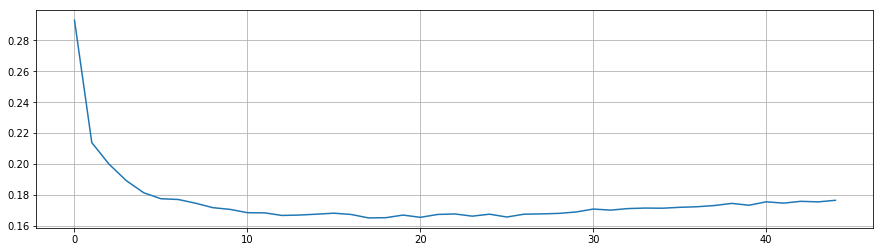

In [0]:
#TODO load data and label from local dir into data/label vars here and remove google drive code

nn = train_optimal(data, label)
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

testing = False
if testing:
  procdata = np.copy(data)
  preprocess(procdata, 'zscore')
  train, train_target, test_data, test_target = split(procdata, label)
  test_target = OHE(test_target, 10)
  preds = nn.predict(test_data)
  acc = calc_accuracy(labels_from_preds(preds), labels_from_preds(test_target)) # we have to de-OHE the predictions and the target data
  print("Final accuracy on test set was {}".format(acc))
else:
  #load test data here
  #preprocess the data
  #OHE the labels
  #predict
  #save in h5 file in /Output




In [0]:
np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(data, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)
second_layer = False
relu = False
if second_layer:
  nn = MLP([128,60,30,10], [None,'logistic','logistic','tanh'])
elif relu:
  nn = MLP([128,60,10], [None, 'relu', 'relu'], False)
  start = time.time()
  MSE = nn.fit_mb_BN(train, train_target, 32, learning_rate=0.001, epochs=25, dropout_p=1)
  print("{}s to train".format(time.time() - start))
else:
  nn = MLP([128,60,10], [None,'logistic','tanh'], False)
  start = time.time()
  MSE = nn.fit_mb_BN(train, train_target, 32, learning_rate=0.01, epochs=25, dropout_p=1)
  print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

ValueError: ignored

In [0]:
len(train)
len(validate)
train.shape

In [0]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

In [0]:
# Read in results tables as DataFrame
df_results_2layers = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Results_Tables/table_2_layers.csv')
df_results_3layers = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Results_Tables/table_3_layers.csv')

# Convert to latex
table_2layers = df_results_2layers.to_latex()
table_3layers = df_results_3layers.to_latex()

In [0]:
print(table_2layers)

\begin{tabular}{llllllllllllllllllllllllllll}
\toprule
{} &     Experiment number &         1 &         2 &       2.1 &         3 &       3.1 &       3.2 &         4 &         5 &         6 &         7 &       7.1 &       7.3 &       7.4 &       7.5 &       7.6 &       7.7 &         8 &       8.1 &       8.2 &       8.3 &         9 &       9.1 &       9.2 &        10 &      10.1 &      10.2 \\
\midrule
0  &  Number hidden layers &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 &         2 \\
1  &        Initialisation &       uni &      norm &      norm &      norm &      norm &      norm &       uni &       uni &       uni &       uni &       uni &      norm &       uni &       uni &       uni &       uni &      norm &      norm &      no

Louis testing stuff below

In [0]:

np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(procdata, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)


nn = MLP([128,109,90, 71, 52, 33,10], [None, 'leaky_relu','leaky_relu','leaky_relu','leaky_relu','leaky_relu', 'softmax'])
nn.set_early_stopping(validate, validate_target, 40)
start = time.time()
MSE = nn.fit_mb(train, train_target, learning_rate=0.005,mini_batch_size=32, epochs=15, dropout_p=0.7)
print("{}s to train".format(time.time() - start))

print('loss:%f'%MSE[-1])

.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: underflow encountered in square
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/scipy/special/_logsumexp.py:112: RuntimeWarning: underflow encountered in exp
  tmp = np.exp(a - a_max)
/usr/local/lib/python3.6/dist-packages/scipy/special/_logsumexp.py:215: RuntimeWarning: underflow encountered in exp
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


.105.25821876525879s to train
loss:0.232365


In [0]:
preds = nn.predict(validate)
calc_accuracy(labels_from_preds(preds), labels_from_preds(validate_target))

0.8737777777777778

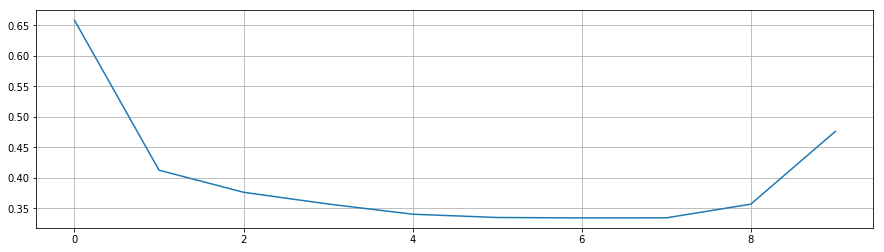

In [0]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

In [0]:
print(len(MSE))

55
